In [1]:
import cv2 as cv
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
import glob
import os
from google.colab.patches import cv2_imshow
from skimage.exposure import match_histograms
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [2]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t 



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/Dataset.zip -d Dataset
!unzip -q /content/drive/MyDrive/Patterns.zip -d Patterns

In [5]:
filelist = [file for file in os.listdir('/content/Dataset') if file.endswith('.jpg') or file.endswith('.png')]

# **Preprocessing Phase**

In [6]:
def detector(image1,image2):
    # creating ORB detector
    detect = cv2.ORB_create()
    # finding key points and descriptors of both images using detectAndCompute() function
    key_point1,descrip1 = detect.detectAndCompute(image1,None)
    key_point2,descrip2 = detect.detectAndCompute(image2,None)
    return (key_point1,descrip1,key_point2,descrip2)

In [7]:
def BF_FeatureMatcher(des1,des2):
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    no_of_matches = brute_force.match(des1,des2)
  
    # finding the humming distance of the matches and sorting them
    no_of_matches = sorted(no_of_matches,key=lambda x:x.distance)[:10]
    return no_of_matches

In [8]:
def display_output(pic1,kpt1,pic2,kpt2,best_match):
  
    # drawing the feature matches using drawMatches() function
    output_image = cv2.drawMatches(pic1,kpt1,pic2,kpt2,best_match,None,flags=2)
    cv2_imshow(output_image)

In [9]:
def matching(img, img_pattern):
  key_pt1, descrip1, key_pt2, descrip2 = detector(img,img_pattern)
    
  matches = BF_FeatureMatcher(descrip1,descrip2)
  # tot_feature_matches = len(matches)
  # print(f'Total Number of Features matches found are {tot_feature_matches}')
    
  # display_output(gray_pic1, key_pt1, gray_pic2,key_pt2, matches)
  list_kp1 = [[int(key_pt1[mat.queryIdx].pt[0]), int(key_pt1[mat.queryIdx].pt[1])] for mat in matches] 
  list_kp2 = [[int(key_pt2[mat.trainIdx].pt[0]), int(key_pt2[mat.trainIdx].pt[1])] for mat in matches]

  kp1 = np.array(list_kp1, np.float32)
  kp2 = np.array(list_kp2, np.float32)
  h, status = cv2.findHomography(kp1, kp2, cv.RANSAC)
  cropped = cv2.warpPerspective(img, h, (img.shape[1], img.shape[0]))

  # matched = match_histograms(img_pattern, cropped, multichannel=True)
  return cropped, h

In [10]:
def transform_point(point, t):
  x = t[0][0] * point[0] + t[0][1] * point[1] + t[0][2]
  y = t[1][0] * point[0] + t[1][1] * point[1] + t[1][2]
  z = t[2][0] * point[0] + t[2][1] * point[1] + t[2][2]
  x_transformed = np.int32(x / z)
  y_transformed = np.int32(y / z)
  return np.array([[x_transformed, y_transformed]])

In [11]:
def generate_mask(image, json_file, t):
  mask = np.zeros((image.shape[0], image.shape[1]))
  for shape in json_file['shapes']:
    points = np.array(shape['points'], dtype = "float32")
    points = np.array([points])
    for point in points:
      temp = transform_point(point, t)
      cv2.fillPoly(mask, pts=[temp.astype(np.int32)], color=(255, 255, 255))
  return mask

In [12]:
def dataset_generator(images, patterns, masks):
  x_train = []
  y_train = []
  for i, img in enumerate(images):
    im = img
    p = patterns[i]
    y = masks[i]
    x = np.concatenate((im, p), axis=2)
    x_train.append(x)
    y_train.append(y)
  return x_train, y_train

In [13]:
images = []
patterns = []
masks = []

for img_name in filelist:
  json_name = img_name[:-3] + "json"
  f = open('/content/Dataset/' + json_name, encoding="utf8")
  json_file = json.load(f)
  f.close()
  img = cv.imread('/content/Dataset/' + img_name)
  img_pattern = cv.imread('/content/Patterns/' + json_file['pattern'])

  img_pattern = cv.resize(img_pattern, img.shape[:2][::-1])
  matched_img, t = matching(img, img_pattern)

  mask = generate_mask(matched_img, json_file, t)

  matched_img = cv.resize(matched_img, (256, 256))
  img_pattern = cv.resize(img_pattern, (256, 256))
  mask = cv.resize(mask, (256, 256))

  images.append(matched_img)
  patterns.append(img_pattern)
  masks.append(mask)

In [31]:
x_train, y_train = dataset_generator(images, patterns, masks)

In [32]:
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = np.expand_dims(y_train, axis=-1)

In [33]:
y_train.shape

(301, 256, 256, 1)

In [34]:
x_train.shape

(301, 256, 256, 6)

# **Create the Model**

In [18]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [19]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [20]:
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)

   return x

In [21]:
def build_unet_model(): 
   inputs = layers.Input(shape=(256, 256, 6))
   f1, p1 = downsample_block(inputs, 64)
   f2, p2 = downsample_block(p1, 128)
   f3, p3 = downsample_block(p2, 256)
   f4, p4 = downsample_block(p3, 512)
   bottleneck = double_conv_block(p4, 1024)
   u6 = upsample_block(bottleneck, f4, 512)
   u7 = upsample_block(u6, f3, 256)
   u8 = upsample_block(u7, f2, 128)
   u9 = upsample_block(u8, f1, 64)
   outputs = layers.Conv2D(1, 1, padding="valid", activation = "sigmoid")(u9)
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [22]:
unet_model = build_unet_model()

In [23]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  3520        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [24]:
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15)

In [26]:
history = unet_model.fit(x_train, y_train,
                    batch_size=32,
                    validation_data=[x_test, y_test],
                    epochs=5)

Epoch 1/5
8/8 [==============================] - 77s 6s/step - loss: 37.9381 - accuracy: 0.8883 - val_loss: 5.9883 - val_accuracy: 0.9998
Epoch 2/5
8/8 [==============================] - 15s 2s/step - loss: 4.6211 - accuracy: 0.9741 - val_loss: 4.3019 - val_accuracy: 0.9998
Epoch 3/5
8/8 [==============================] - 15s 2s/step - loss: 3.4410 - accuracy: 0.9999 - val_loss: 2.6051 - val_accuracy: 0.9998
Epoch 4/5
8/8 [==============================] - 15s 2s/step - loss: 1.6622 - accuracy: 0.9999 - val_loss: 0.7945 - val_accuracy: 0.9998
Epoch 5/5
8/8 [==============================] - 15s 2s/step - loss: 0.6441 - accuracy: 0.9975 - val_loss: 0.2624 - val_accuracy: 0.9998


# **Show an example**

Text(0.5, 1.0, 'Pattern')

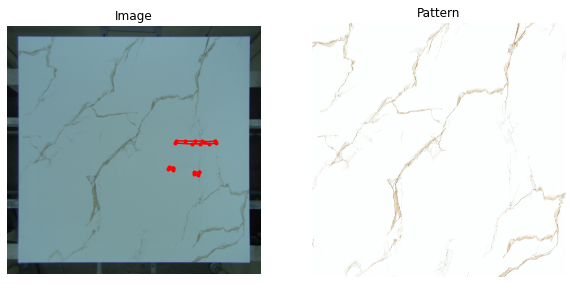

In [ ]:
img_name = filelist[0]
json_name = img_name[:-3] + "json"
f = open('/content/Dataset/' + json_name, encoding="utf8")
json_file = json.load(f)
f.close()
img = cv.imread('/content/Dataset/' + img_name)
img_pattern = cv.imread('/content/Patterns/' + json_file['pattern'])

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img[..., ::-1])
plt.axis('off')
plt.title("Image")
for shape in json_file["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  
fig.add_subplot(1, 2, 2)
plt.imshow(img_pattern[..., ::-1])
plt.axis('off')
plt.title("Pattern")

In [ ]:
gray_pic1, gray_pic2 = convert_to_grayscale(img, img_pattern)
gray_pic1 = cv.resize(gray_pic1, (500, 500))
gray_pic2 = cv.resize(gray_pic2, (500, 500))
# storing the finded key points and descriptors of both of the images
key_pt1, descrip1, key_pt2, descrip2 = detector(gray_pic1,gray_pic2)
  
matches = BF_FeatureMatcher(descrip1,descrip2)
tot_feature_matches = len(matches)
# printing total number of feature matches found
print(f'Total Number of Features matches found are {tot_feature_matches}')
  
# after drawing the feature matches displaying the output image
# display_output(gray_pic1, key_pt1, gray_pic2,key_pt2, matches)
list_kp1 = [[key_pt1[mat.queryIdx].pt[0], key_pt1[mat.queryIdx].pt[1]] for mat in matches] 
list_kp2 = [[key_pt2[mat.trainIdx].pt[0], key_pt2[mat.trainIdx].pt[1]] for mat in matches]

Total Number of Features matches found are 91


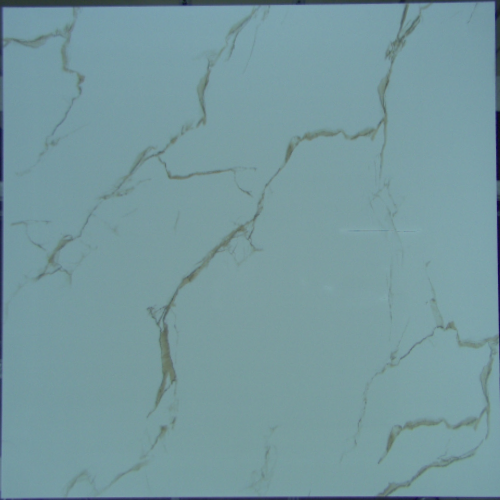

In [ ]:
im = cv2.resize(img, (500, 500))
kp1 = np.array(list_kp1, np.float32)
kp2 = np.array(list_kp2, np.float32)
h, status = cv2.findHomography(kp1, kp2, cv.RANSAC, 5.0)
cropped = cv2.warpPerspective(im, h, (500, 500))
cv2_imshow(cropped)

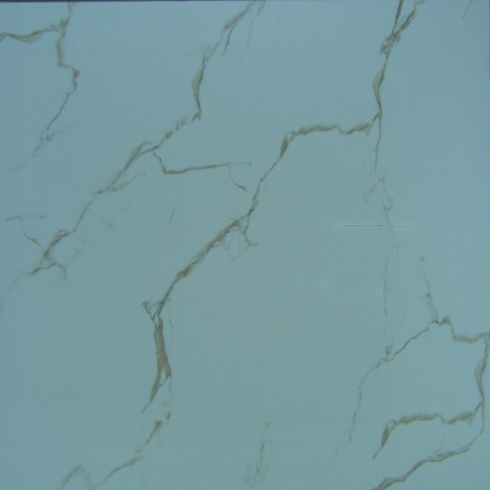

In [ ]:
crop = cropped[5:495, 5:495]
cv2_imshow(crop)

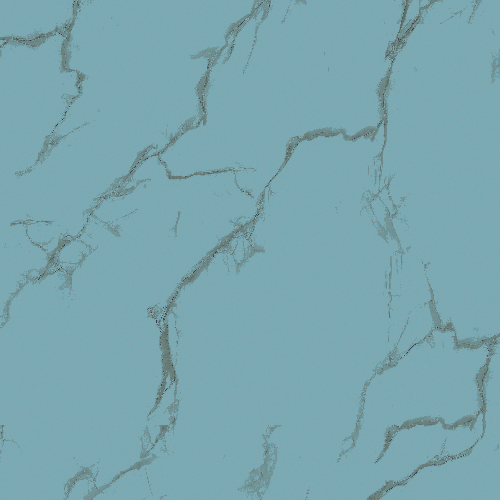

In [ ]:
matched = match_histograms(img_pattern, crop, multichannel=True)
new_p = cv.resize(matched, (500,500))
cv2_imshow(new_p)

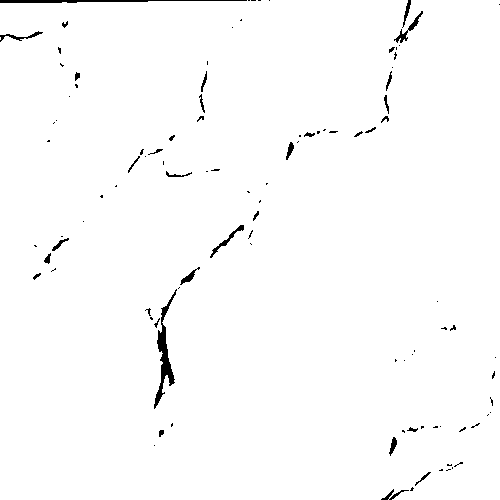

In [ ]:
g2 = cv.cvtColor(crop, cv2.COLOR_BGR2GRAY)
ret, th2 = cv2.threshold(g2, 120, 255, cv2.THRESH_BINARY)
cv2_imshow(th2)

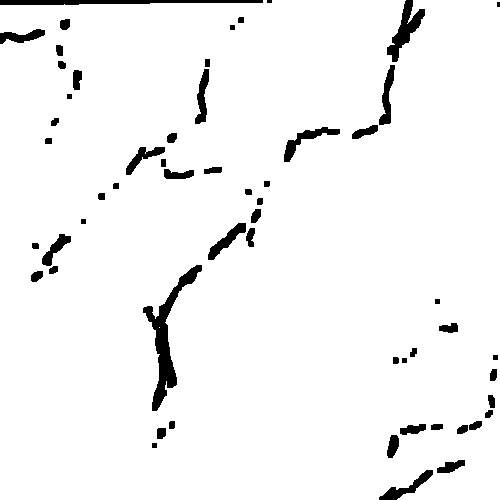

In [ ]:
kernel = np.ones((5, 5), np.uint8)
img_erosion1 = cv2.erode(th2, kernel, iterations=1)
cv2_imshow(img_erosion1)

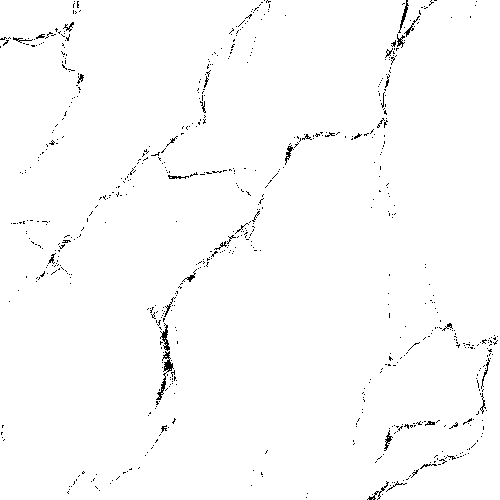

In [ ]:
g1 = cv.cvtColor(new_p, cv2.COLOR_BGR2GRAY)
ret, th1 = cv2.threshold(g1, 120, 255, cv2.THRESH_BINARY)
cv2_imshow(th1)

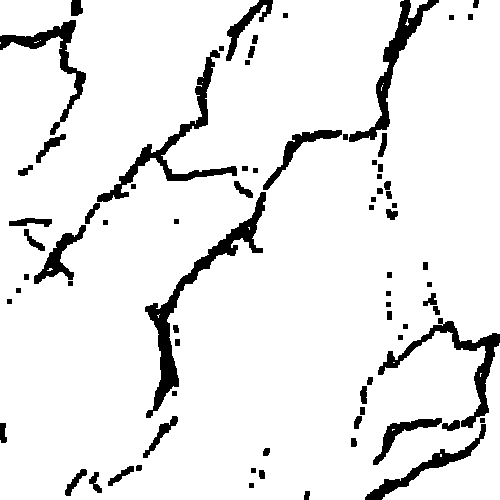

In [ ]:
kernel = np.ones((5, 5), np.uint8)
img_erosion2 = cv2.erode(th1, kernel, iterations=1)
cv2_imshow(img_erosion2)

In [ ]:
crop = cv.resize(crop, (500, 500))

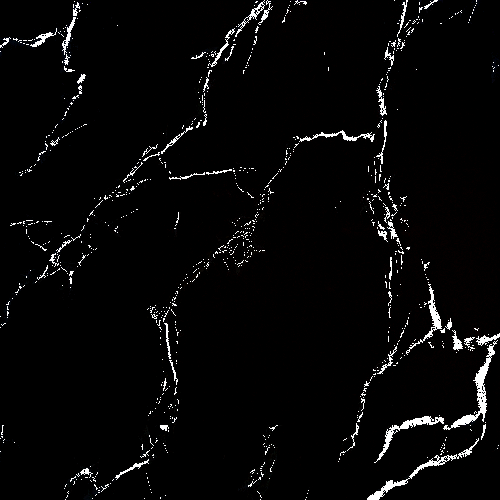

In [ ]:
difference = cv2.subtract(crop, new_p)
Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
difference[mask != 255] = [255, 255, 255]
cv2_imshow(difference)

In [ ]:
he , w, c = img.shape
arr1 = np.array([[0, 0], [0, he], [w, 0], [he, w]])
arr2 = np.array([[0, 0], [0, 500], [500, 0], [500, 500]])
m, s = cv2.findHomography(arr1, arr2, cv.RANSAC, 5.0)

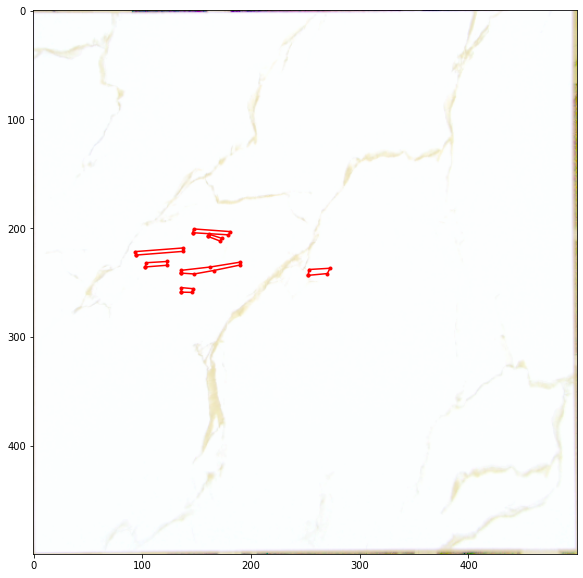

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(matched[..., ::-1])
for shape in json_file["shapes"]:
  points = np.array(shape['points'])
  points = np.array([points])
  temp = cv.perspectiveTransform(points, m)
  new_patterns = cv.perspectiveTransform(temp, h)
  ind = list(np.arange(new_patterns[0].shape[0])) + [0]
  plt.plot(new_patterns[0, ind, 0], new_patterns[0, ind, 1], 'r.-')
  